In [13]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.preprocessing.image import image_dataset_from_directory
from keras import layers
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
DATA_FOLDER = "../input/hindi-mnist-data"
TRAIN_FOLDER_NAME = "Train"
TEST_FOLDER_NAME = "Test"
DEVANAGARI_DATA_FOLDER = os.path.join(DATA_FOLDER, "DevanagariHandwrittenDigitDataset")
print(DEVANAGARI_DATA_FOLDER)

../input/hindi-mnist-data/DevanagariHandwrittenDigitDataset


In [3]:
labels_to_keep = [
    "digit_0", "digit_1", "digit_2", "digit_3", "digit_4", "digit_5", "digit_6", "digit_7", "digit_8", "digit_9"
]

### Dataset and Model Parameters

In [18]:
RANDOM_SEED = 42

# Data parameters
IMG_HEIGHT = 32
IMG_WIDTH = 32
VALIDATION_SPLIT = 0.1

# Model parameters
BATCH_SIZE = 32
KERNEL_SIZE = (3, 3)
MAX_POOLING_SIZE = (2, 2)
num_classes = len(labels_to_keep)

In [5]:
classes = labels_to_keep
classes_to_output_class_names = {
    "digit_0": "0", "digit_1": "1", "digit_2": "2", "digit_3": "3", "digit_4": "4", "digit_5": "5", "digit_6": "6",
    "digit_7": "7", "digit_8": "8", "digit_9": "9"
}


print("Gathering training dataset...")
train_dataset = image_dataset_from_directory(
    os.path.join(DEVANAGARI_DATA_FOLDER, TRAIN_FOLDER_NAME),
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=RANDOM_SEED,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

print("Gathering validation dataset...")
val_dataset = image_dataset_from_directory(
    os.path.join(DEVANAGARI_DATA_FOLDER, TRAIN_FOLDER_NAME),
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=RANDOM_SEED,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

print("Gathering test dataset...")
test_dataset = image_dataset_from_directory(
    os.path.join(DEVANAGARI_DATA_FOLDER, TEST_FOLDER_NAME),
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=RANDOM_SEED,
    validation_split=None,  # None, so that we get all the data.
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Gathering training dataset...
Found 17000 files belonging to 10 classes.
Using 15300 files for training.


2022-11-20 21:14:48.149475: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Gathering validation dataset...
Found 17000 files belonging to 10 classes.
Using 1700 files for validation.
Gathering test dataset...
Found 3000 files belonging to 10 classes.


In [16]:
train_dataset

<BatchDataset shapes: ((None, 32, 32, 1), (None,)), types: (tf.float32, tf.int32)>

In [6]:
train_dataset.element_spec

(TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [7]:
class_names_to_labels = dict([(cls_name, lbl) for cls_name, lbl in zip(classes, list(range(len(classes))))])
# print(class_names_to_labels)
labels_to_class_names = dict([(v, k) for k, v in class_names_to_labels.items()])
print(labels_to_class_names)

{0: 'digit_0', 1: 'digit_1', 2: 'digit_2', 3: 'digit_3', 4: 'digit_4', 5: 'digit_5', 6: 'digit_6', 7: 'digit_7', 8: 'digit_8', 9: 'digit_9'}


### Look at the data
Let us take a look at the data after it has been stored as a tensorflow tf.Data.Dataset object.

2022-11-20 21:15:45.219786: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(32, 32, 1)


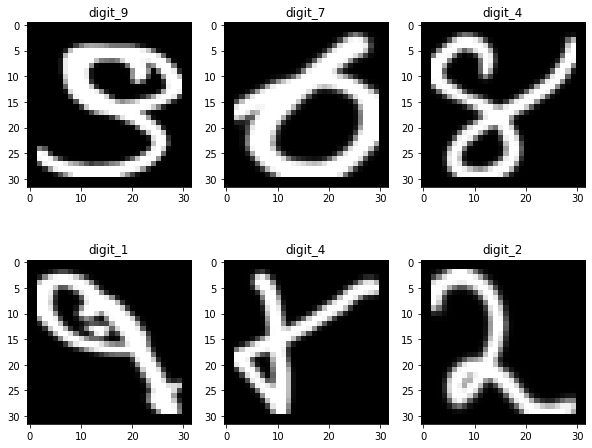

In [8]:
# Take a look at the input data
rows = 2
columns = 3
fig = plt.figure(figsize=(10, 8))
j = 1
for images, labels in train_dataset.take(1):
    print(images[0].shape)
    for i, l in zip(images[:6], labels[:6]):
        fig.add_subplot(rows, columns, j)
        plt.imshow(tf.squeeze(i), cmap='gray', vmin=0, vmax=255)
        plt.title(labels_to_class_names[int(l)])
        j += 1

In [9]:
# Scale images to the [0, 1] range
normalization_layer = layers.Rescaling(1. / 255)


In [10]:
model = keras.Sequential(
    [
        normalization_layer,
        layers.Conv2D(32, kernel_size=KERNEL_SIZE, activation="relu"),
        layers.MaxPooling2D(pool_size=MAX_POOLING_SIZE),
        layers.Conv2D(64, kernel_size=KERNEL_SIZE, activation="relu"),
        layers.MaxPooling2D(pool_size=MAX_POOLING_SIZE),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

### Compiling and Building Model


In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(input_shape=(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (32, 32, 32, 1)           0         
_________________________________________________________________
conv2d (Conv2D)              (32, 30, 30, 32)          320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 15, 15, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 13, 13, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 6, 6, 64)            0         
_________________________________________________________________
flatten (Flatten)            (32, 2304)                0         
_________________________________________________________________
dense (Dense)                (32, 128)                 2

In [12]:
epochs = 15
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


479/479 [==============================] - 13s 25ms/step - loss: 0.2070 - accuracy: 0.9373 - val_loss: 0.0674 - val_accuracy: 0.9794
Epoch 2/15
479/479 [==============================] - 10s 21ms/step - loss: 0.0448 - accuracy: 0.9858 - val_loss: 0.0309 - val_accuracy: 0.9876
Epoch 3/15
479/479 [==============================] - 9s 19ms/step - loss: 0.0207 - accuracy: 0.9941 - val_loss: 0.0307 - val_accuracy: 0.9888
Epoch 4/15
479/479 [==============================] - 9s 20ms/step - loss: 0.0123 - accuracy: 0.9965 - val_loss: 0.0250 - val_accuracy: 0.9894
Epoch 5/15
479/479 [==============================] - 10s 21ms/step - loss: 0.0121 - accuracy: 0.9963 - val_loss: 0.0384 - val_accuracy: 0.9871
Epoch 6/15
479/479 [==============================] - 9s 20ms/step - loss: 0.0072 - accuracy: 0.9979 - val_loss: 0.0293 - val_accuracy: 0.9906
Epoch 7/15
479/479 [==============================] - 10s 21ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0283 - val_accuracy: 0.9906
Epoch 

### Measuring Performance on Training and Test Data

In [17]:
print("Evaluate")
result = model.evaluate(test_dataset)
result

Evaluate
94/94 [==============================] - 1s 9ms/step - loss: 0.0272 - accuracy: 0.9943


[0.027152404189109802, 0.9943333268165588]